In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
from  datetime import datetime,timedelta,time

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)


In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head(10)

,station_id,stationname,date,daytype,rides
0,40850,Library,10/09/2004,A,1057
1,40780,Central Park,06/18/2010,W,1154
2,41500,Montrose-Brown,10/30/2001,W,2116
3,40500,Washington/State,10/26/2006,W,0
4,41090,Monroe/State,07/07/2010,W,9431
5,40080,Sheridan,05/29/2009,W,5601
6,40350,UIC-Halsted,12/06/2008,A,2038
7,40550,Irving Park-O'Hare,01/14/2009,W,4122
8,40260,State/Lake,05/06/2013,W,9512
9,40200,Randolph/Wabash,05/18/2011,W,7093


## Data Exploration

In [4]:
df['date'] = pd.to_datetime(df['date'])
 
# Create year column
df['year'] = pd.DatetimeIndex(df['date']).year

# Create month column
df['month'] = pd.DatetimeIndex(df['date']).month

#Filter data from 2002 to 2017
data = df.loc[df['year']>=2002].loc[ df['year']<=2017]


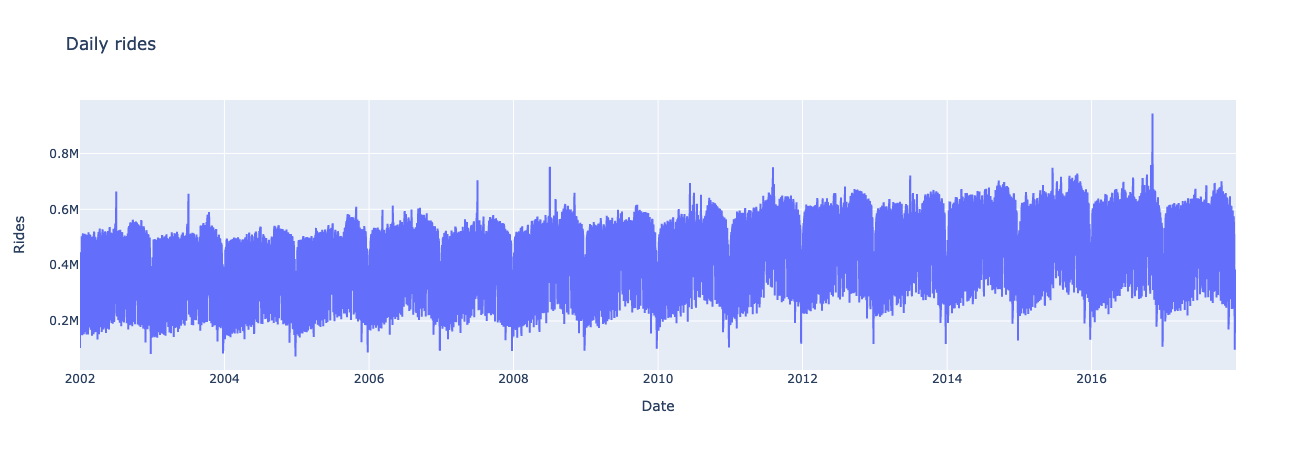

In [5]:
## Plotting interactive plotly plot to visualize the trend of overall rides over time. We can zoom into this plot and interact with it and explore it.  
data['date'] = pd.to_datetime(data['date'])
daily_rides = data.groupby([ 'date'], as_index=False)['rides'].sum()

daily_rides_sc = go.Scatter(x=daily_rides['date'], y=daily_rides['rides'])
layout = go.Layout(title='Daily rides', xaxis=dict(title='Date'), yaxis=dict(title='Rides'))
fig = go.Figure(data=[daily_rides_sc], layout=layout)
iplot(fig)

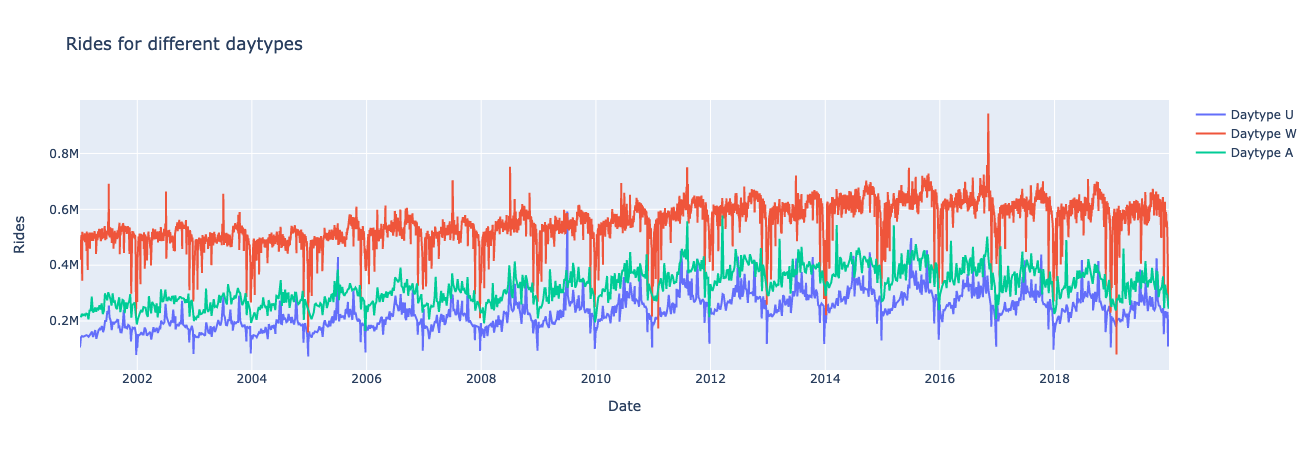

In [6]:
## Explore individual features now. Let's start with the daytype feature. 

daytype_rides = df.groupby(['date', 'daytype'], as_index=False)['rides'].sum()

daytype_rides_sc = []
for daytype in daytype_rides['daytype'].unique():
    current_daytype_rides = daytype_rides[(daytype_rides['daytype'] == daytype)]
    daytype_rides_sc.append(go.Scatter(x=current_daytype_rides['date'], y=current_daytype_rides['rides'], name=('Daytype %s' % daytype)))

layout = go.Layout(title='Rides for different daytypes', xaxis=dict(title='Date'), yaxis=dict(title='Rides'))
fig = go.Figure(data=daytype_rides_sc, layout=layout)
iplot(fig)


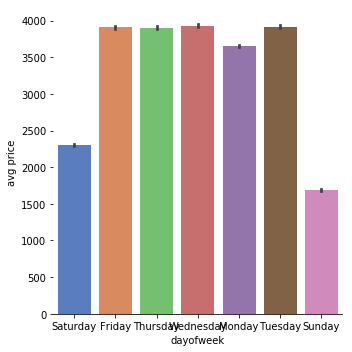

In [7]:
## Clearly daytype is a important feature. Let's check if further division of weekdays is useful.
data['dayofweek'] = data['date'].dt.day_name()

g = sns.catplot(x="dayofweek",y="rides" , data=data, kind="bar", height = 5 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("avg price")


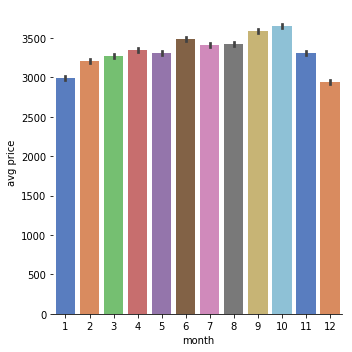

In [8]:
## Since the weekdays behave almost similar it is okay to have the daytype categorization at the level we already have(weekday, saturday, sunday/holiday). 
data = data.drop('dayofweek', axis=1 )

## Let's check if the month is a useful feature.
g = sns.catplot(x="month",y="rides" , data=data, kind="bar", height = 5 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("avg price")

## Looks like it is.

#### Missing data snd duplicate data.

In [9]:
# Now, check for number of days for which the data is available and avg number of rides for each station

datacount= data.groupby('station_id', as_index=False).agg({'rides':'mean','date':'count'})
datacount.columns=['station_id','avg_rides','num_days']


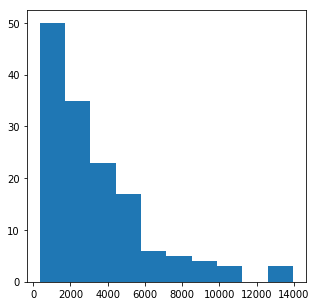

In [10]:
plt.figure(figsize=(5,5))
plt.hist(datacount['avg_rides']);


Clearly the distribution of the rides across different stations are very different

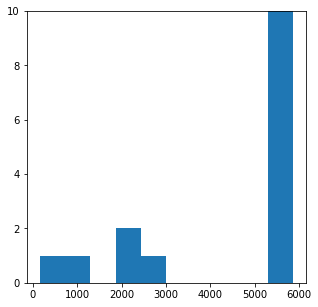

In [11]:
# Plot the distribution of stations across number of days data available for
plt.figure(figsize=(5,5))
plt.hist(datacount['num_days'])
plt.ylim(0,10);

In [12]:
# Check the top highest number of days data available for
datacount.sort_values(by='num_days',ascending=False).head(5)

,station_id,avg_rides,num_days
44,40470,1840.002558,5864
139,41500,1956.461617,5862
75,40790,5008.320423,5861
20,40220,1230.970995,5861
125,41330,1761.972696,5860


In [13]:
# Check the lowest number of days data available for
datacount.sort_values(by='num_days',ascending=False).tail(5)

,station_id,avg_rides,num_days
47,40500,4691.631762,2588
143,41680,704.268920,2101
140,41510,2018.105263,2071
144,41690,1203.648723,1096
145,41700,6646.986928,153


#### There are missing data for many stations. Check for Duplicate data.

In [14]:
data.groupby(['station_id','date'], as_index=False)['rides'].count().sort_values(by='rides',ascending=False)

,station_id,date,rides
91145,40170,2011-07-18,2
812298,41500,2011-08-10,2
800609,41480,2011-08-09,2
800610,41480,2011-08-10,2
333230,40600,2011-07-01,2
...,...,...,...
277382,40510,2002-08-05,1
277383,40510,2002-08-06,1
277384,40510,2002-08-07,1
277385,40510,2002-08-08,1


In [15]:
## Check for duplicate entries
data[(data.station_id==40470) & (data.date=='2011-07-19')]

,station_id,stationname,date,daytype,rides,year,month
216809,40470,Racine,2011-07-19,W,1797,2011,7
446004,40470,Racine,2011-07-19,W,1785,2011,7


In [16]:
data[(data.station_id==41500) & (data.date=='2011-08-10')]

,station_id,stationname,date,daytype,rides,year,month
368806,41500,Montrose-Brown,2011-08-10,W,2513,2011,8
555229,41500,Montrose-Brown,2011-08-10,W,2528,2011,8


In [17]:
## Since duplicate entries have slightly different number of rides, we can take average of that.
data = data.groupby(['station_id','stationname','date','daytype', 'year','month'], as_index=False)['rides'].mean()

#Now check for duplicate entries again
data.groupby(['station_id','date'], as_index=False)['rides'].count().sort_values(by='rides',ascending=False).head()

,station_id,date,rides
0,40010,2002-01-01,1
554499,41010,2009-07-18,1
554489,41010,2009-07-08,1
554490,41010,2009-07-09,1
554491,41010,2009-07-10,1


### Plots of rides for individual stations.

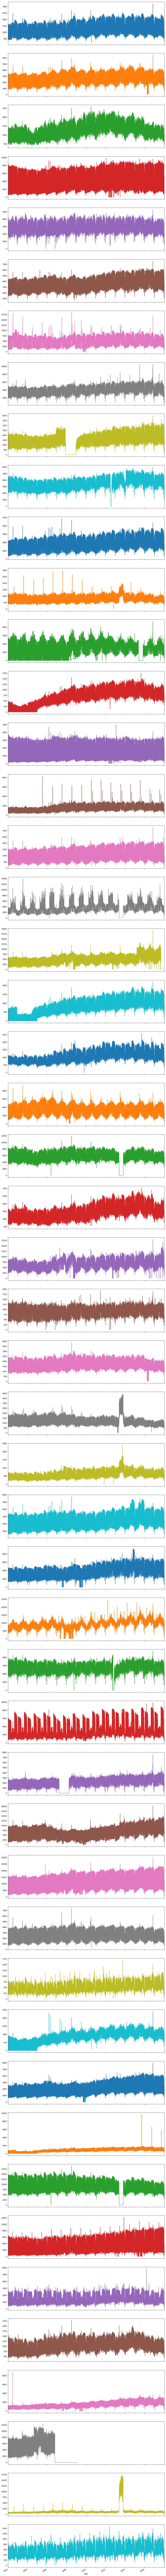

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 300

## Let's plot the rides data for individual stations separately and see if there is any pattern
t = (data.set_index(["station_id", "date"])["rides"].unstack().iloc[:50].T.plot(legend=None, subplots = True))

# Findings and Learnings:
1. It is a time series data and different stations have very different ranges and trends of data.
2. There is seasonality in data. We can see patterns repeating yearly. 
3. Few stations have spikes(could be outlier, data error or true values) and flat zeros(could be missing data or no rides happened) in the data.
4. Some stations have no rides after certain year(station closed).
5. The pattern of data has remained pretty consistent across years. Although we see a slight increase in scale over time for few stations. However we can reduce the size of the data and can take only data after 2010 for modeling. This can reduce the computational load without much loss of the information from the data. Infact it will reduce noise since we can see pretty consistent patterns after 2010. 
6. Since the time series for each station is quite different building one time series model for the combined data won't be accurate way to approach this problem.
7. Also, building separate time series model for each station might not be feasible for the production environment as there are 146 stations and hence 146 different time series models. 


# My approach

Due to above mentioned reasons my approach to this problem will be to extract time dependent features from the data and then use them as predictors in a regression model. I will be extracting features such as min, max, mean, median, std, skew, count from the rides data 7days, 14days, 28days and 84days prior to the day on which the rides is to be predicted. I also extract these features again grouped at daytypes. Another feature is exponentially decaying mean rides with rides happened on recent past given more weight than rides which happened long back.  

Also from the plots above it is confirmed that the month of the year and type of day has clear impact on the number of rides. Hence I extract these features for month, stationtype and daytype, stationtype level for the entire data from 2010 to 2016. 


In [19]:
#Filter data from 2010 to 2017 
data = data.loc[data['year']>=2010].loc[ data['year']<=2017]


In [20]:
## Function to calculate the time series features mentioned above 

def calculate_features(df, data, num_days):
    if num_days == 7:
        name_str = '1w'
    elif num_days == 14:
        name_str = '2w'
    elif num_days == 28:
        name_str = '4w'
    elif num_days == 84:
        name_str = '12w'


    df1 = df[['station_id','date']].copy()
    # Define the cutoff date or start date since when the data is to be considered for the calculations. 
    df1['start_date'] = df1.apply(lambda x: x.date - timedelta(days=num_days), axis=1)
    df1 = df1.rename(columns={'date':'end_date'})
    
    ## Join with the rides data and filter the data for the relevant time window(between start date and end date defined)
    relevant_data = pd.merge( df1, data, on = 'station_id', how = 'inner')
    relevant_data = relevant_data[(relevant_data.date>=relevant_data.start_date) & (relevant_data.date < relevant_data.end_date) ]

    ## Calculate min, max, mean, median, std, skew on the data for the given timeframe
    station_result = relevant_data.groupby(['station_id','end_date'], as_index=False)['rides'].agg({'station_min{}'.format(name_str): 'min',
                                                                             'station_mean{}'.format(name_str): 'mean',
                                                                             'station_median{}'.format(name_str): 'median',
                                                                             'station_max{}'.format(name_str): 'max',
                                                                             'station_std{}'.format(name_str): 'std',
                                                                             'station_skew{}'.format(name_str): 'skew'})

    merged_result = station_result.rename(columns={'end_date':'date'})   
    
    ## When the time window is greater than 28 then calculate the above features for specific daytypes
    if num_days>=28:    
        station_dtype_result = relevant_data.groupby(['station_id','end_date','daytype'], as_index=False)['rides'].agg({'station_dtype_min{}'.format(name_str): 'min',
                                                                                 'station_dtype_mean{}'.format(name_str): 'mean',
                                                                                 'station_dtype_median{}'.format(name_str): 'median',
                                                                                 'station_dtype_max{}'.format(name_str): 'max',
                                                                                 'station_dtype_count{}'.format(name_str): 'count',
                                                                                 'station_dtype_std{}'.format(name_str): 'std',
                                                                                 'station_dtype_skew{}'.format(name_str): 'skew'})
        station_dtype_result = station_dtype_result.rename(columns={'end_date':'date'})
        
        temp_df1= df[['station_id','date','daytype']].copy()
        
        station_dtype_result = temp_df1.merge(station_dtype_result,on=['station_id','date','daytype'], how='inner').drop('daytype', axis=1)
        merged_result = merged_result.merge(station_dtype_result, on=['station_id','date'], how='inner').fillna(0)
    
    ## Add exponential mean rides feature with the decay factor of 0.985 
    relevant_data['num_days'] = relevant_data.apply(lambda x: (x.end_date - x.date).days , axis=1)    
    relevant_data['weight'] = relevant_data['num_days'].apply(lambda x: 0.985**x)
    relevant_data['weighted_rides'] = relevant_data['rides'] * relevant_data['weight']
    
    result1 = relevant_data.groupby(['station_id','end_date'], as_index=False)['weighted_rides'].agg({'station_exp_sum{}'.format(name_str): 'sum'}) 
    result2 = relevant_data.groupby(['station_id','end_date'], as_index=False)['weight'].agg({'station_exp_weight_sum{}'.format(name_str): 'sum'})
    station_exp_result = result1.merge(result2, on=['station_id','end_date'], how='inner')   
    station_exp_result['station_exp_mean{}'.format(name_str)] = station_exp_result['station_exp_sum{}'.format(name_str)]/station_exp_result['station_exp_weight_sum{}'.format(name_str)]
    station_exp_result = station_exp_result.drop( ['station_exp_sum{}'.format(name_str), 'station_exp_weight_sum{}'.format(name_str)], axis=1)
    
    station_exp_result = station_exp_result.rename(columns={'end_date':'date'})
    merged_result = merged_result.merge(station_exp_result, on=['station_id','date'], how='inner').fillna(0)
    
    ## Return the merged dataframe which inclues all the calculated features
    return merged_result
    
    
 

In [185]:
## Due to computational constraints we will calculate the above features on only three years of data. 
## This does not affect the results much as most of the information is captured within this time window.

target_data= data.loc[data['year']>=2015].loc[ data['year']<=2017]
rides = data.loc[data['year']>=2014].loc[ data['year']<=2017]
target_data.shape

(157977, 7)

In [186]:
# Features for 1 week time window
features_1w = calculate_features(target_data,rides, 7)
features_1w.head()


,station_id,date,station_min1w,station_mean1w,station_median1w,station_max1w,station_std1w,station_skew1w,station_exp_mean1w
0,40010,2015-01-01,533.0,1159.857143,1149.0,1821.0,491.701274,0.041712,1171.512991
1,40010,2015-01-02,587.0,1167.571429,1149.0,1821.0,480.523970,0.099927,1170.003719
2,40010,2015-01-03,587.0,1201.428571,1386.0,1821.0,487.298970,-0.175516,1205.100074
3,40010,2015-01-04,587.0,1194.571429,1386.0,1821.0,493.643886,-0.153557,1192.346642
4,40010,2015-01-05,587.0,1184.714286,1386.0,1821.0,505.843426,-0.167843,1174.561791


In [187]:
# Features for 2 weeks time window
features_2w = calculate_features(target_data,rides, 14)
features_2w.head()


,station_id,date,station_min2w,station_mean2w,station_median2w,station_max2w,station_std2w,station_skew2w,station_exp_mean2w
0,40010,2015-01-01,533.0,1314.071429,1363.0,2009.0,493.559671,-0.148195,1309.847681
1,40010,2015-01-02,533.0,1212.500000,1174.5,1929.0,485.805240,0.024318,1208.486420
2,40010,2015-01-03,533.0,1173.714286,1174.5,1821.0,444.085652,-0.033214,1176.584024
3,40010,2015-01-04,533.0,1158.285714,1174.5,1821.0,454.185057,0.036572,1156.960611
4,40010,2015-01-05,533.0,1148.142857,1174.5,1821.0,465.051007,0.028545,1139.942079


In [188]:
# Features for 4 weeks or 1 month time window
features_4w = calculate_features(target_data,rides, 28)
features_4w.head()


,station_id,date,station_min4w,station_mean4w,station_median4w,station_max4w,station_std4w,station_skew4w,station_dtype_min4w,station_dtype_mean4w,station_dtype_median4w,station_dtype_max4w,station_dtype_count4w,station_dtype_std4w,station_dtype_skew4w,station_exp_mean4w
0,40010,2015-01-01,533.0,1544.785714,1686.0,2264.0,564.179073,-0.365188,533.0,717.800000,756.0,839.0,5,115.419669,-1.184051,1517.911175
1,40010,2015-01-02,533.0,1484.892857,1610.0,2238.0,573.930267,-0.272335,1149.0,1850.833333,1969.0,2238.0,18,322.063065,-1.023001,1456.198020
2,40010,2015-01-03,533.0,1454.464286,1544.5,2182.0,554.789749,-0.224121,833.0,1021.500000,1049.5,1154.0,4,140.666272,-0.941916,1430.885918
3,40010,2015-01-04,533.0,1443.285714,1544.5,2182.0,565.292180,-0.204212,533.0,696.000000,725.0,839.0,6,116.227363,-0.406537,1412.285531
4,40010,2015-01-05,533.0,1438.607143,1544.5,2182.0,571.696911,-0.218645,1149.0,1803.500000,1904.0,2182.0,18,324.414631,-0.811944,1396.746264


In [189]:
# Features for 12 weeks or 3 months time window
features_12w = calculate_features(target_data,rides, 84)
features_12w.head()


,station_id,date,station_min12w,station_mean12w,station_median12w,station_max12w,station_std12w,station_skew12w,station_dtype_min12w,station_dtype_mean12w,station_dtype_median12w,station_dtype_max12w,station_dtype_count12w,station_dtype_std12w,station_dtype_skew12w,station_exp_mean12w
0,40010,2015-01-01,533.0,1733.845238,2045.5,2450.0,630.134629,-0.527307,533.0,769.000000,771.0,989.0,14,105.698410,-0.147268,1663.111781
1,40010,2015-01-02,533.0,1711.821429,2027.5,2450.0,637.548622,-0.491317,990.0,2103.263158,2199.0,2450.0,57,320.168344,-1.793771,1636.127019
2,40010,2015-01-03,533.0,1699.154762,2017.5,2429.0,633.261200,-0.461116,833.0,1046.166667,1045.0,1169.0,12,90.515527,-0.953920,1626.138875
3,40010,2015-01-04,533.0,1695.261905,2017.5,2429.0,637.902193,-0.459068,533.0,756.866667,767.0,989.0,15,112.171340,-0.089203,1611.605203
4,40010,2015-01-05,533.0,1690.928571,2017.5,2429.0,643.965235,-0.465921,990.0,2084.596491,2182.0,2429.0,57,330.443796,-1.666406,1594.672675


In [190]:
## Merge the features of 1w, 2w, 4w and 12w window
merged_2w = pd.merge(features_1w,features_2w, on = ['station_id','date'], how = 'inner')
merged_4w = pd.merge(merged_2w, features_4w, on = ['station_id','date'], how = 'inner')
merged_12w = pd.merge(merged_4w, features_12w, on = ['station_id','date'], how = 'inner')

merged_12w.fillna(0,inplace = True)
print(merged_12w.shape)
merged_12w.head()

(157971, 44)


,station_id,date,station_min1w,station_mean1w,station_median1w,station_max1w,station_std1w,station_skew1w,station_exp_mean1w,station_min2w,...,station_std12w,station_skew12w,station_dtype_min12w,station_dtype_mean12w,station_dtype_median12w,station_dtype_max12w,station_dtype_count12w,station_dtype_std12w,station_dtype_skew12w,station_exp_mean12w
0,40010,2015-01-01,533.0,1159.857143,1149.0,1821.0,491.701274,0.041712,1171.512991,533.0,...,630.134629,-0.527307,533.0,769.000000,771.0,989.0,14,105.698410,-0.147268,1663.111781
1,40010,2015-01-02,587.0,1167.571429,1149.0,1821.0,480.523970,0.099927,1170.003719,533.0,...,637.548622,-0.491317,990.0,2103.263158,2199.0,2450.0,57,320.168344,-1.793771,1636.127019
2,40010,2015-01-03,587.0,1201.428571,1386.0,1821.0,487.298970,-0.175516,1205.100074,533.0,...,633.261200,-0.461116,833.0,1046.166667,1045.0,1169.0,12,90.515527,-0.953920,1626.138875
3,40010,2015-01-04,587.0,1194.571429,1386.0,1821.0,493.643886,-0.153557,1192.346642,533.0,...,637.902193,-0.459068,533.0,756.866667,767.0,989.0,15,112.171340,-0.089203,1611.605203
4,40010,2015-01-05,587.0,1184.714286,1386.0,1821.0,505.843426,-0.167843,1174.561791,533.0,...,643.965235,-0.465921,990.0,2084.596491,2182.0,2429.0,57,330.443796,-1.666406,1594.672675


In [191]:
# Save the file as later steps can be carried out using this file. Above steps are computationally heavy. 
merged_12w.to_csv('merged_features_file.csv', index=False)

In [24]:
merged_12w = pd.read_csv('merged_features_file.csv')
merged_12w['date'] = pd.to_datetime(merged_12w['date'] )

In [25]:
## Calculate features specific to month and daytype since we can clearly see their effect on the rides in the plot
## We will use only the training data for this feature caluclation. Presence of test data will bias this feature. Hence we remove the test data. 
trainonly = data.loc[data.year<2017]

monthly_result = trainonly.groupby(['station_id','month'], as_index=False)['rides'].agg({'station_month_min': 'min',
                                                                             'station_month_mean': 'mean',
                                                                             'station_month_median': 'median',
                                                                             'station_month_max': 'max',
                                                                             'station_month_std': 'std',
                                                                             'station_month_skew': 'skew'})

daytype_result = trainonly.groupby(['station_id','daytype'], as_index=False)['rides'].agg({'station_daytype_min': 'min',
                                                                             'station_daytype_mean': 'mean',
                                                                             'station_daytype_median': 'median',
                                                                             'station_daytype_max': 'max',
                                                                             'station_daytype_std': 'std',
                                                                             'station_daytype_skew': 'skew'})  

## Merge the above month specific and daytype specific features with the overall data file
data = data.merge(monthly_result, on=['station_id','month'], how='inner')
data = data.merge(daytype_result, on=['station_id','daytype'], how='inner')

data.head()

,station_id,stationname,date,daytype,year,month,rides,station_month_min_x,station_month_mean_x,station_month_median_x,...,station_month_median_y,station_month_max_y,station_month_std_y,station_month_skew_y,station_daytype_min_y,station_daytype_mean_y,station_daytype_median_y,station_daytype_max_y,station_daytype_std_y,station_daytype_skew_y
0,40010,Austin-Forest Park,2010-01-01,U,2010,1,800.0,406.0,1497.820276,1754.0,...,1754.0,2251.0,603.869183,-0.460482,379.0,763.651106,767.0,1445.0,134.294934,0.582732
1,40010,Austin-Forest Park,2010-01-03,U,2010,1,406.0,406.0,1497.820276,1754.0,...,1754.0,2251.0,603.869183,-0.460482,379.0,763.651106,767.0,1445.0,134.294934,0.582732
2,40010,Austin-Forest Park,2010-01-10,U,2010,1,488.0,406.0,1497.820276,1754.0,...,1754.0,2251.0,603.869183,-0.460482,379.0,763.651106,767.0,1445.0,134.294934,0.582732
3,40010,Austin-Forest Park,2010-01-17,U,2010,1,526.0,406.0,1497.820276,1754.0,...,1754.0,2251.0,603.869183,-0.460482,379.0,763.651106,767.0,1445.0,134.294934,0.582732
4,40010,Austin-Forest Park,2010-01-24,U,2010,1,534.0,406.0,1497.820276,1754.0,...,1754.0,2251.0,603.869183,-0.460482,379.0,763.651106,767.0,1445.0,134.294934,0.582732


In [26]:
## Merge all the calculated features to generate the final data
finaldata = data.merge(merged_12w, on = ['station_id','date'], how='inner')
finaldata.head()


,station_id,stationname,date,daytype,year,month,rides,station_month_min_x,station_month_mean_x,station_month_median_x,...,station_std12w,station_skew12w,station_dtype_min12w,station_dtype_mean12w,station_dtype_median12w,station_dtype_max12w,station_dtype_count12w,station_dtype_std12w,station_dtype_skew12w,station_exp_mean12w
0,40010,Austin-Forest Park,2015-01-01,U,2015,1,587.0,406.0,1497.820276,1754.0,...,630.134629,-0.527307,533.0,769.000000,771.0,989.0,14,105.698410,-0.147268,1663.111781
1,40010,Austin-Forest Park,2015-01-04,U,2015,1,625.0,406.0,1497.820276,1754.0,...,637.902193,-0.459068,533.0,756.866667,767.0,989.0,15,112.171340,-0.089203,1611.605203
2,40010,Austin-Forest Park,2015-01-11,U,2015,1,588.0,406.0,1497.820276,1754.0,...,631.177658,-0.363535,533.0,732.600000,758.0,890.0,15,96.667176,-0.601359,1559.085134
3,40010,Austin-Forest Park,2015-01-18,U,2015,1,706.0,406.0,1497.820276,1754.0,...,623.261255,-0.380496,533.0,712.466667,756.0,839.0,15,92.919986,-0.625678,1561.005729
4,40010,Austin-Forest Park,2015-01-25,U,2015,1,585.0,406.0,1497.820276,1754.0,...,611.910067,-0.372159,533.0,707.000000,721.0,839.0,15,90.540441,-0.514927,1554.131191


In [27]:
## Separate all the calculated features to generate the final data
train = finaldata.loc[finaldata['year']>=2015].loc[ data['year']<=2016]
test = finaldata.loc[finaldata['year']==2017]

In [28]:
train.head()

,station_id,stationname,date,daytype,year,month,rides,station_month_min_x,station_month_mean_x,station_month_median_x,...,station_std12w,station_skew12w,station_dtype_min12w,station_dtype_mean12w,station_dtype_median12w,station_dtype_max12w,station_dtype_count12w,station_dtype_std12w,station_dtype_skew12w,station_exp_mean12w
0,40010,Austin-Forest Park,2015-01-01,U,2015,1,587.0,406.0,1497.820276,1754.0,...,630.134629,-0.527307,533.0,769.000000,771.0,989.0,14,105.698410,-0.147268,1663.111781
1,40010,Austin-Forest Park,2015-01-04,U,2015,1,625.0,406.0,1497.820276,1754.0,...,637.902193,-0.459068,533.0,756.866667,767.0,989.0,15,112.171340,-0.089203,1611.605203
2,40010,Austin-Forest Park,2015-01-11,U,2015,1,588.0,406.0,1497.820276,1754.0,...,631.177658,-0.363535,533.0,732.600000,758.0,890.0,15,96.667176,-0.601359,1559.085134
3,40010,Austin-Forest Park,2015-01-18,U,2015,1,706.0,406.0,1497.820276,1754.0,...,623.261255,-0.380496,533.0,712.466667,756.0,839.0,15,92.919986,-0.625678,1561.005729
4,40010,Austin-Forest Park,2015-01-25,U,2015,1,585.0,406.0,1497.820276,1754.0,...,611.910067,-0.372159,533.0,707.000000,721.0,839.0,15,90.540441,-0.514927,1554.131191


In [29]:
test.head()

,station_id,stationname,date,daytype,year,month,rides,station_month_min_x,station_month_mean_x,station_month_median_x,...,station_std12w,station_skew12w,station_dtype_min12w,station_dtype_mean12w,station_dtype_median12w,station_dtype_max12w,station_dtype_count12w,station_dtype_std12w,station_dtype_skew12w,station_exp_mean12w
11,40010,Austin-Forest Park,2017-01-01,U,2017,1,553.0,406.0,1497.820276,1754.0,...,665.593729,-0.358180,417.0,671.571429,695.0,930.0,14,118.860432,-0.053978,1587.438439
12,40010,Austin-Forest Park,2017-01-02,U,2017,1,746.0,406.0,1497.820276,1754.0,...,671.885710,-0.367913,417.0,644.642857,663.0,770.0,14,96.389919,-0.992607,1569.712218
13,40010,Austin-Forest Park,2017-01-08,U,2017,1,507.0,406.0,1497.820276,1754.0,...,667.036804,-0.246770,417.0,651.400000,686.0,770.0,15,96.500037,-1.055771,1524.638865
14,40010,Austin-Forest Park,2017-01-15,U,2017,1,600.0,406.0,1497.820276,1754.0,...,662.352558,-0.249716,417.0,633.866667,640.0,746.0,15,97.301348,-0.817542,1523.724524
15,40010,Austin-Forest Park,2017-01-22,U,2017,1,603.0,406.0,1497.820276,1754.0,...,654.386670,-0.233087,417.0,626.933333,632.0,746.0,15,95.638058,-0.645687,1532.502968


## Model building 

In [31]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt

## Select the features that we want to use in training
predictors = [f for f in train.columns if f not in (['station_id','stationname','date','daytype','year','month','rides'])]

## Since out output variable is continuous, let's start building the model with a linear regression model 
lm = linear_model.LinearRegression()
model = lm.fit(train[predictors], train['rides'])
lm.score(train[predictors], train['rides'])

0.9714083733824416

In [32]:
predictions = lm.predict(test[predictors])
predictions

array([429.66366503, 426.52239168, 458.85941138, ..., 628.07399361,
       922.41375013, 596.71434856])

In [33]:
## R squared value of the model
lm.score(test[predictors], test['rides'])

0.9724112687093714

In [34]:
# Root mean squared value of the model 
rms = sqrt(mean_squared_error(test['rides'], predictions))
rms

583.9480149094678

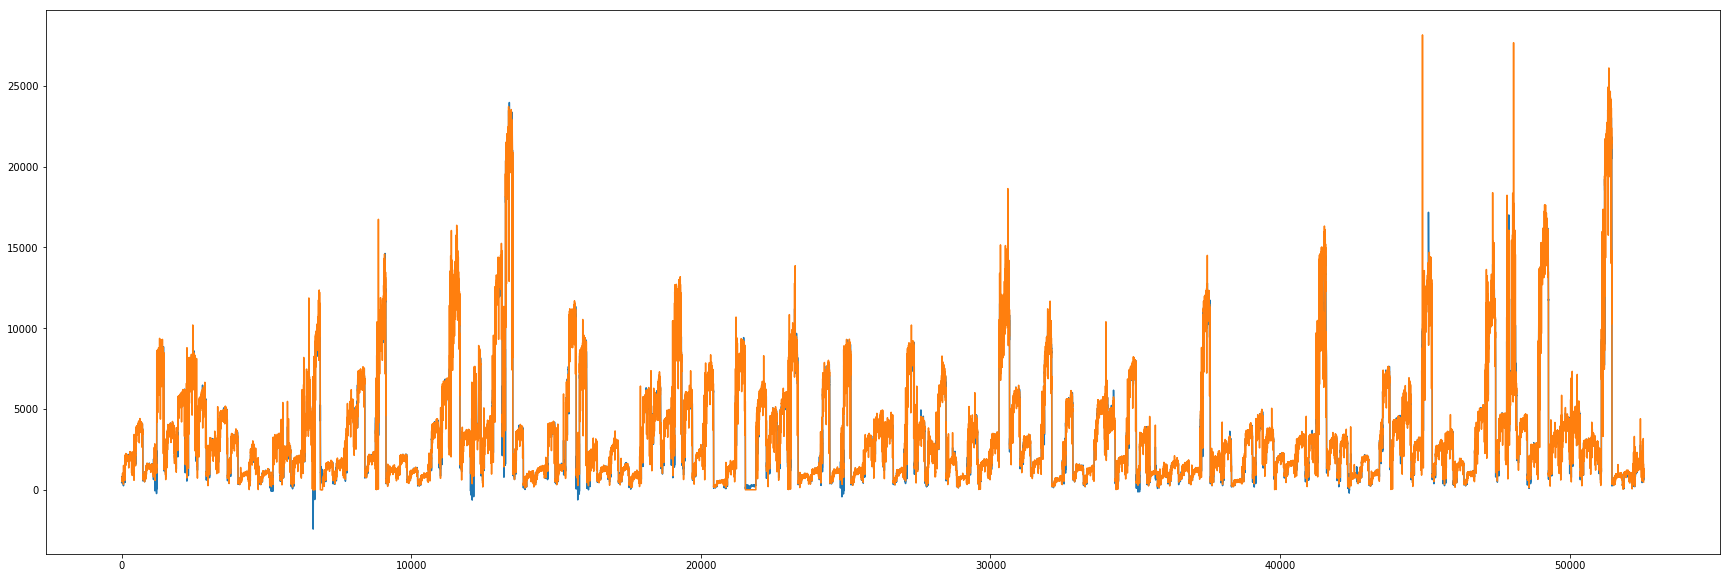

In [35]:
# Plot the true and fitted predicted values of rides for 2017
fig= plt.figure(figsize=(30,10))
x = np.array([i for i in range(len(test))])
plt.plot(x,predictions)
plt.plot(x, test['rides'])
plt.show()

## Observations:
1. Overall 97% R squared value indicates the regressors are able to explain the 97% variation in the rides. 
2. Root mean squared value of 588 might or mightnot be too bad for the given scale of the rides and the nature of the problem depending upon the accuracy requirements of the transport department. 
3. Some predicted values are negative which is not possible in real life. 
4. We can improve this model further.
5. Next, I will try lightgbm model. 

In [36]:
import datetime
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

I used Gridserach cross validation to get an idea of the range of the optimal parameters for the lightgbm. Have commented it now as this step is computationally very heavy. Run only when parameter estimates are need. Uncomment the following code when needed. 

In [37]:
# param_grid = {
#     'num_leaves': [500, 750, 1000, 1500, 2000],
#     'reg_alpha': [0.1, 0.2],
#     'min_data_in_leaf': [10, 15, 30]}

# gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=train[predictors], y=train['rides'])
# lgb_estimator = lgb.LGBMRegressor(learning_rate= 0.02, boosting_type= 'gbdt',metric= 'rmse')
# gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
# lgb_model = gsearch.fit(X=train[predictors], y=train['rides'])
# print(lgb_model.best_params_, lgb_model.best_score_)

In [38]:
## Define the parameters for the lightgbm based on the output from the cross validation
params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 1600,
    'min_data': 7,
    'min_hessian': 0.1
}

## Prepare dataset
lgb_train = lgb.Dataset(train[predictors], train['rides'])
lgb_test = lgb.Dataset(test[predictors], test['rides'])

## Train the model 
gbm = lgb.train(params,lgb_train,2000)

## Predict the rides for test data using the model
pred = gbm.predict(test[predictors])

In [39]:
## Calculate the root mean squared error for the predictions
rms = sqrt(mean_squared_error(test['rides'], pred))
rms

203.87852272710035

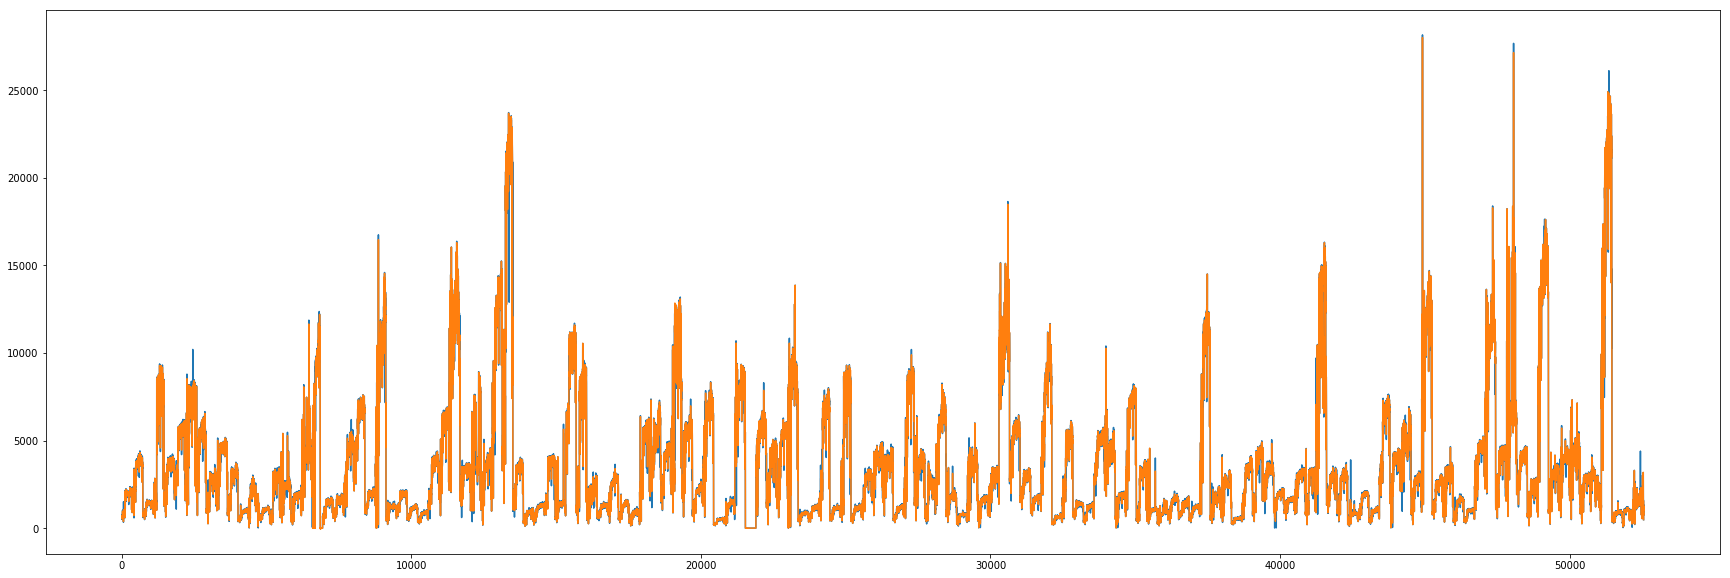

In [40]:
# Plot the true and fitted predicted values of rides for 2017
fig= plt.figure(figsize=(30,10))
x = np.array([i for i in range(len(test))])

plt.plot(x, test['rides'])
plt.plot(x,pred)
plt.show()


### Analysis of errors

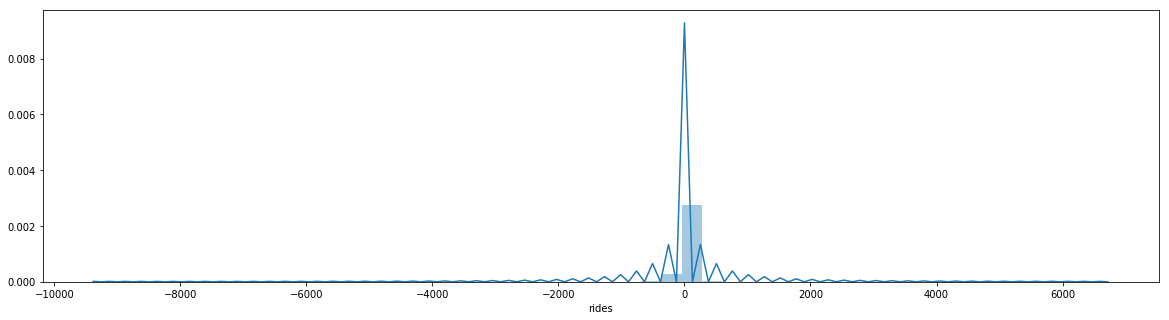

In [41]:
# Let's plot errors
fig= plt.figure(figsize=(20,5))
sns.distplot(test['rides']-pred);

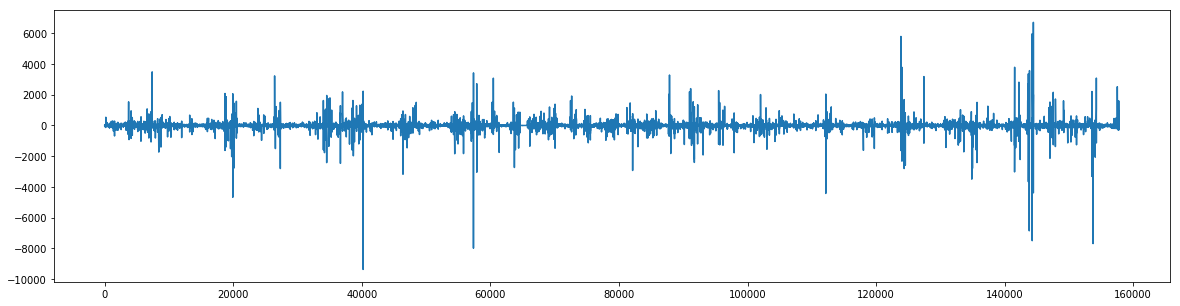

In [42]:
fig= plt.figure(figsize=(20,5))
plt.plot(test['rides']-pred);

Even though majority of errors are centered around 0, we see some errors which are very high. We can look linto the indivdual cases of those stations and try to find if any pattern exists in the errors.

In [44]:
## Add predicted rides and error column to the test data
test['predicted_rides'] = pred
test['prediction_error'] = test['predicted_rides'] - test['rides'] 

# We can then look at the biggest errors made in prediction
test.sort_values(by='prediction_error', ascending=False).head()


,station_id,stationname,date,daytype,year,month,rides,station_month_min_x,station_month_mean_x,station_month_median_x,...,station_dtype_min12w,station_dtype_mean12w,station_dtype_median12w,station_dtype_max12w,station_dtype_count12w,station_dtype_std12w,station_dtype_skew12w,station_exp_mean12w,predicted_rides,prediction_error
40213,40380,Clark/Lake,2017-07-03,W,2017,7,12900.0,5084.0,16138.500000,19841.0,...,17994.0,21776.711864,21897.0,23725.0,59,1063.232256,-0.918537,17110.228383,22271.896510,9371.896510
57374,40560,Jackson/State,2017-01-16,W,2017,1,3878.0,1820.0,8786.889401,9778.0,...,4077.0,10159.719298,9444.0,18909.0,57,2768.259250,0.207996,7453.873459,11866.404826,7988.404826
153755,41660,Lake/State,2017-11-11,A,2017,11,7462.0,4527.0,17035.847619,18233.0,...,11145.0,13324.000000,13322.5,15172.0,12,1350.887049,-0.253014,19183.762706,15151.988290,7689.988290
144286,41420,Addison-North Main,2017-06-26,W,2017,6,7126.0,4460.0,10557.242857,8188.0,...,6332.0,10643.220339,9263.0,18363.0,59,3879.242665,0.199572,10238.528811,14625.884544,7499.884544
143827,41420,Addison-North Main,2017-06-24,A,2017,6,5966.0,4460.0,10557.242857,8188.0,...,5198.0,8851.166667,6616.5,16009.0,12,4170.554592,0.732981,10088.833974,12823.698199,6857.698199


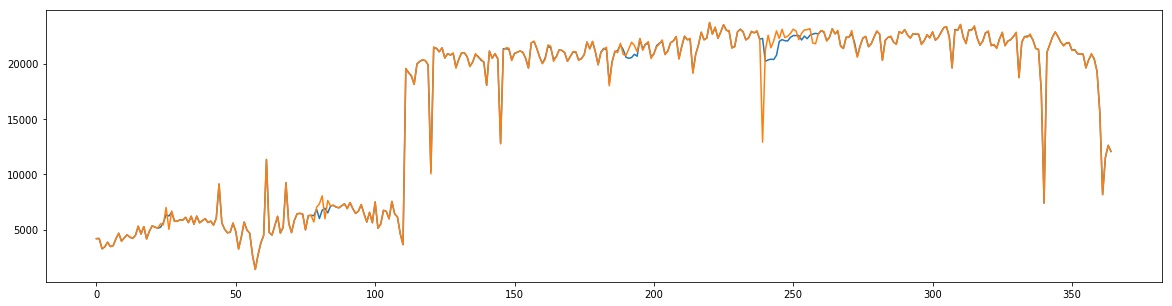

In [45]:
# Plot the true and fitted predicted values of rides for station id= 40380 for which we made the highest error
fig= plt.figure(figsize=(20,5))
test1 = test[test.station_id==40380]
x = np.array([i for i in range(len(test1))])

plt.plot(x,test1['predicted_rides'])
plt.plot(x, test1['rides'])
plt.show()


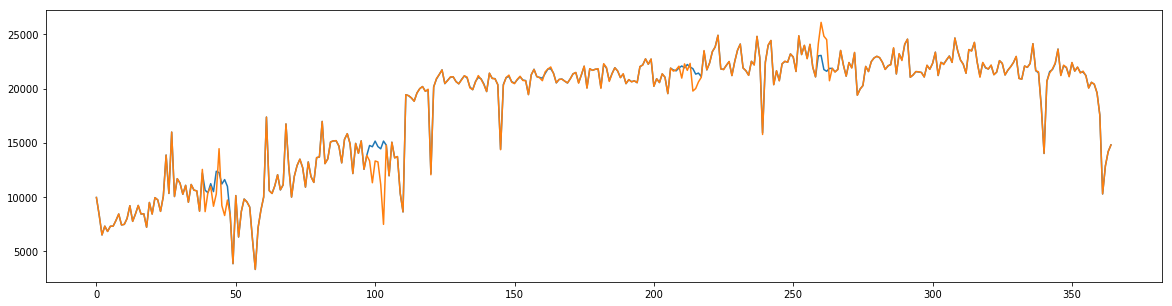

In [46]:
# Plot the true and fitted predicted values of rides for station id= 41660 for which we made the huge error

fig= plt.figure(figsize=(20,5))
test1 = test[test.station_id==41660]
x = np.array([i for i in range(len(test1))])

plt.plot(x,test1['predicted_rides'])
plt.plot(x, test1['rides'])
plt.show()


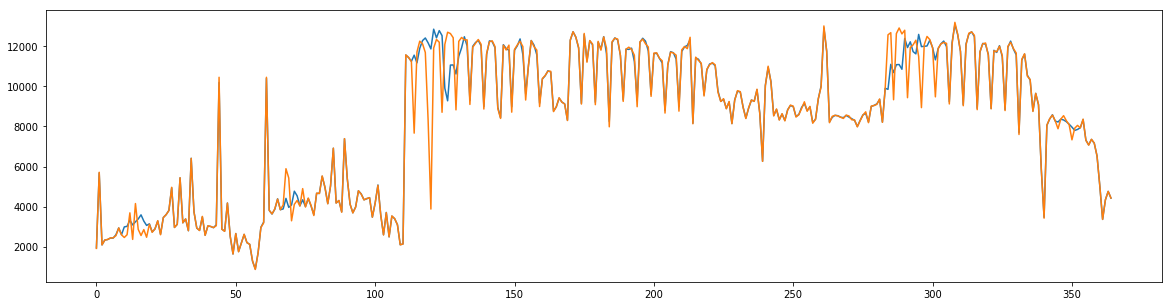

In [47]:
# Plot the true and fitted predicted values of rides for station id= 40560 for which we made the huge error

fig= plt.figure(figsize=(20,5))
test1 = test[test.station_id==40560]
x = np.array([i for i in range(len(test1))])

plt.plot(x,test1['predicted_rides'])
plt.plot(x, test1['rides'])
plt.show()

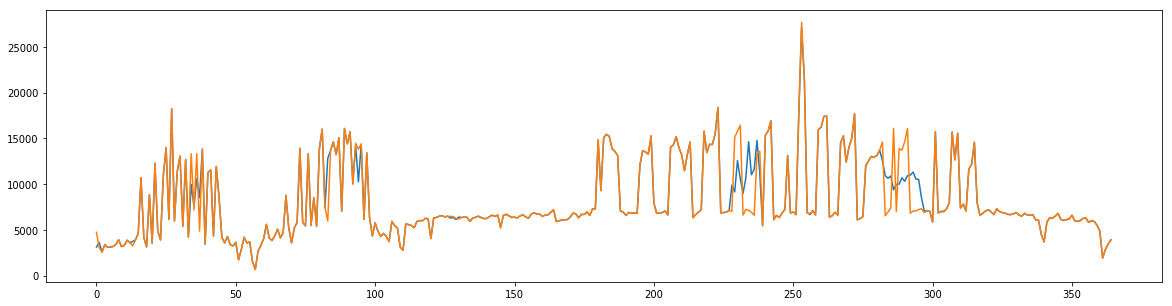

In [48]:
# Plot the true and fitted predicted values of rides for station id= 41420 for which we made the huge error

fig= plt.figure(figsize=(20,5))
test1 = test[test.station_id==41420]
x = np.array([i for i in range(len(test1))])

plt.plot(x,test1['predicted_rides'])
plt.plot(x, test1['rides'])
plt.show()

It does not look like there is any particular pattern in the few cases we explored above. The errors might be due to one of the following reasons:
1. Rain
2. Regional holidays/ festivals
3. Strike/Protest
4. More advanced features needed to capture these senarios.


### Approach and Results
I started off with the data exploration and found that this problem involved time series prediction but also includes categorical variables(stations) and the data for each categorical variable are very different and represents a different time series. However building a separate time series model for each station might not be a good idea as it will become too many models to build and maintain. Instead I tried to build one model for all the stations and tried to incorporate the different features of each station by doing some feature engineering and introducing features that can capture the time series features. Since our dependent variable(rides) is a continuous variable I started the model building with a simple linear regression model using the engineered features as predictors. The root mean squared error(RMSE) of the model on test data(2017) was 583. Next, I tried a lightgbm model with grid search cross validation for the optimal parameters serach. The best model gave RMSE of 203 on test data. This means on an average our prediction of rides for any given station on any given day will be off by around 203. If the range of this error is acceptable we can deploy the model in production. However before deplyoing in production, multiple versions of this model can be built and robustly tested on more data from 2002 onwards that we did not utilize in this task due to computational constraints.     

### Further improvement:
1. Given more time more advanced machine learning and deep learning techniques suitable for this problem such as recurrent neural network can be explored.
2. With more computational resources more days of data can be included in the modelling process. That might be helpful. 


### Dependency:
Following packages should be installed in order to be able to run the script.
1. sklearn
2. lightgbm
3. pandas
4. numpy
5. matplotlib
6. plotly
7. seaborn

